At the top of this section is the presentation summary of the Modeling and Prediction section. After that is all of the exploration to get to the final presentation. I was unsure of what to include as the goal of prediction ultimately failed as dreams appear to be fundamentally random. Regardless, the work done is recorded below.

In [1]:
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sbn

# external package
import pmdarima as pm

# Presentation and Final Prediction Report

## Objective
$$
\LARGE{(y_{t-n}, ..., y_{t-1}, y_t) \to (y_{t+1}, y_{t+2}, ...,y_{t+m})}
$$

## Difficulties
* Dates...
    * gaps
    * formatting
    * errors

## Solution
* dropped the dates
* assume compound scores is good

> Obviously the real solution is to properly and extensively clean the data. But, with over 20,000 diary entries spread across 94 people, this task was simply too great and thus assumptions were made for exploratory purposes.

## Variable Overview

In [2]:
path = 'data/diaries/diary01.csv'
df = pd.read_csv(path, sep='|')
df = df[['compound']].iloc[:420]
df.describe()

,compound
count,420.000000
mean,0.400686
std,0.734930
min,-0.995100
25%,-0.330175
50%,0.861550
75%,0.970875
max,0.999600


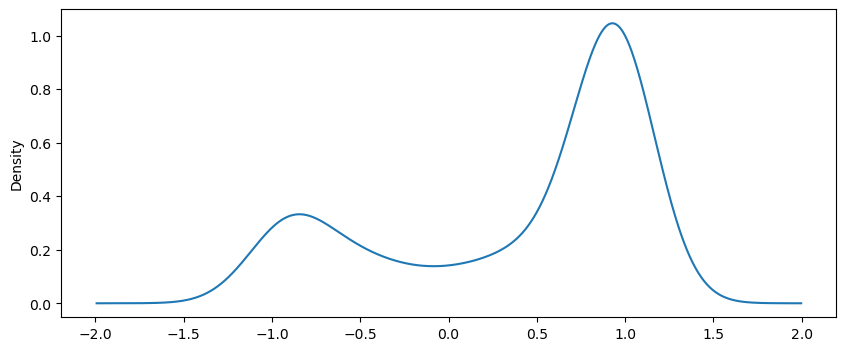

In [3]:
plt.figure(figsize=(10,4))
df.compound.plot(kind='kde');

## Variable Preparation

In [4]:
y = df.compound.values
train = y[:y.size-28]
test = y[y.size-28:]

## Autoregressive (AR) Model
This model is a type of time series model that uses observations from previous time steps as input to the regression equation to predict the value at the next time step.

$$
\LARGE{y_t=\beta_0+\beta_1y_{t-1}+\beta_2y_{t-2}+...+\beta_ky_{t-k}+\epsilon_t}
$$

where
* $y_t$ is the compound score at time $t$, and represents our desired prediction step
* $\beta_0$ is a constant term, and represents the intercept
* $\beta_k$ are the unknown parameters, and represent the influence of each past score on the current score
* $\epsilon_t$ is the unpredictable error at time $t$
* $k$ is the order of the model, and represents how many past observations are used to predict the current value.

> **Note:** that this is the general form for a single prediction into the future. To predict more than one there are a few strategies you could use, but the statsmodels library uses iterative forecasting, which is essentially redoing the whole process with the previously predicted value. Obviously for predictions further into the future the model will degrade over time becoming less and less accurate as it's feeding in it's own values.

## AR Model Assumptions and Checks
* stationary
    * line plot: does the data generally remain near some constant?
* linear dependence on previous values
    * line plot: are previous values close to current values?
    * autocorrelation: are previous lags correlated to current values?

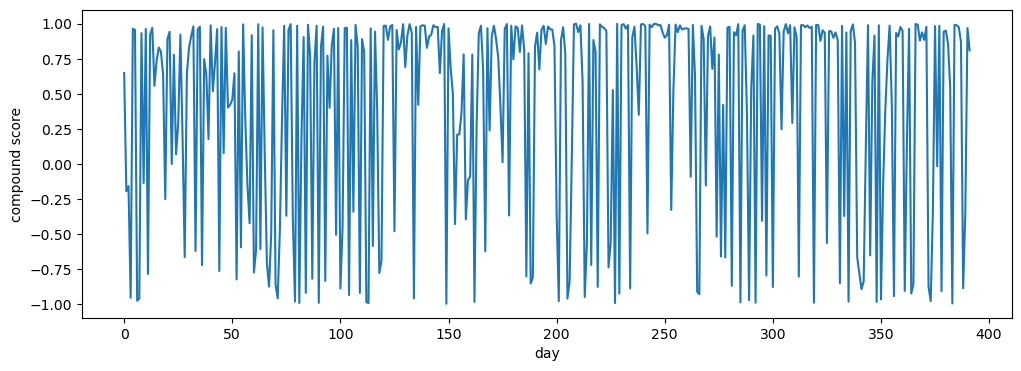

In [5]:
plt.figure(figsize=(12,4))
plt.ylabel('compound score')
plt.xlabel('day')
plt.plot(train);

* stationary confirmed, but obvious
* linear dependence doesn't look good (rapid back and forth)

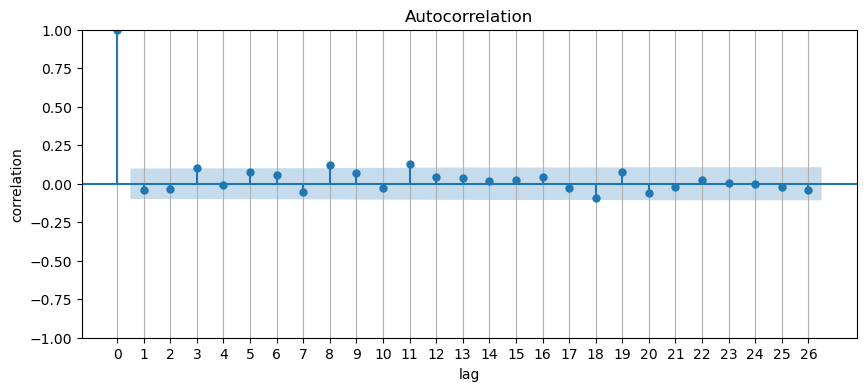

In [6]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
ax.set_xticks(range(0,27))
ax.set_xlabel('lag')
ax.set_ylabel('correlation')
ax.grid(axis='x')
plot_acf(train, ax);

* no correlation found in the lags

## Preprocessing
To try and aleviate some of the rapid back and forth I wanted to try a transformation where I averaged over a range of time periods (3, 7, and 30). For the presentation I will only cover the weekly averages.
> **Note:** Due to the bimodal distribution of the compound score, the mean is a poor metric to use, but was chosen in the hopes it would have the affect of compressing the data to give hints at some patterns.

In [7]:
def apply_to_period(f, x, p):
    """
    Applies a function to the period specified.

    f : func
        Vectorized function to apply.
    x : numpy.array
        Array to use.
    p : int
        Period to use.

    return : numpy.array
        Array after transformation is applied to each period.
    """
    return np.array([
        f( x[i:i+p] )
        for i in np.arange(0, x.size, p)
    ])

In [8]:
y = apply_to_period(np.mean, y, 7)
train = y[:y.size-10]
test = y[y.size-10:]

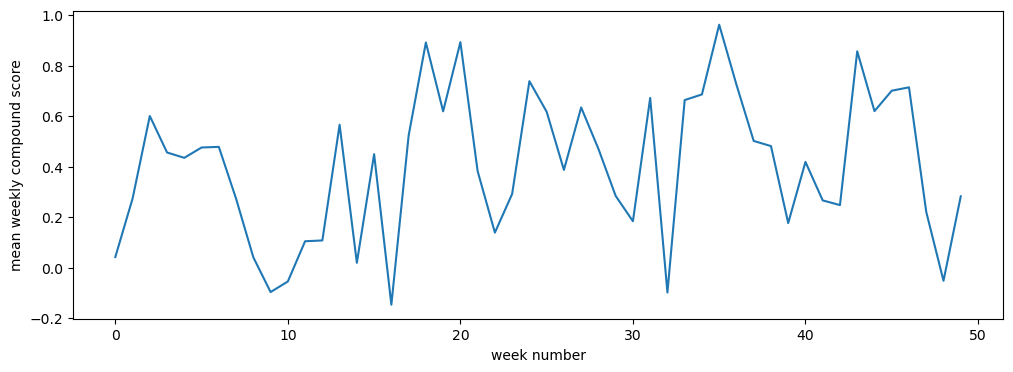

In [9]:
plt.figure(figsize=(12,4))
plt.ylabel('mean weekly compound score')
plt.xlabel('week number')
plt.plot(train);

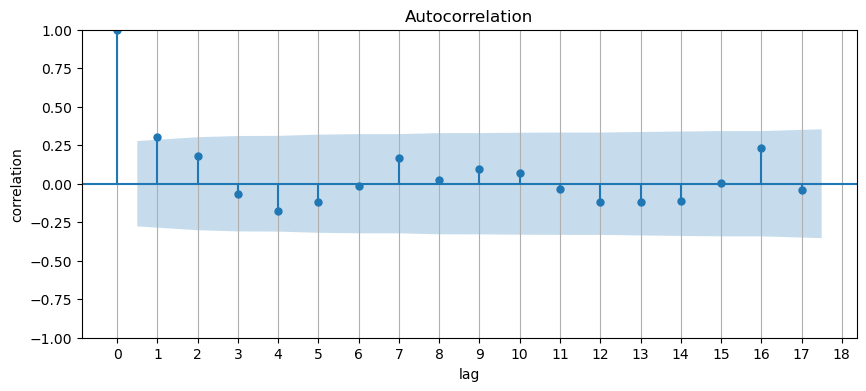

In [10]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
ax.set_xticks(range(0,19))
ax.set_xlabel('lag')
ax.set_ylabel('correlation')
ax.grid(axis='x')
plot_acf(train, ax);

* still bad for the linear dependence assumption
* cyclical pattern is interesting though

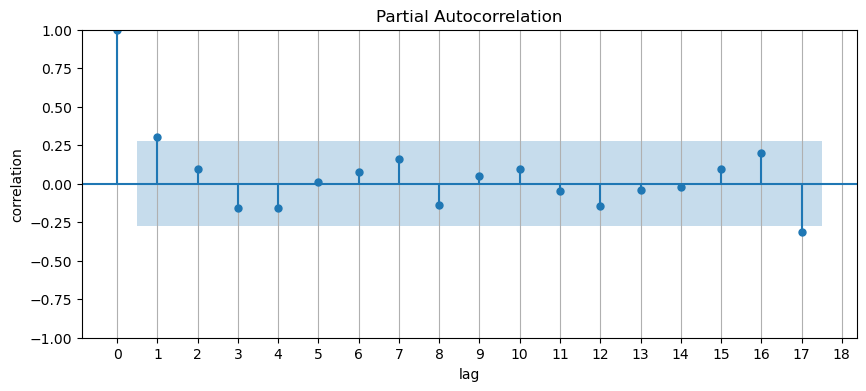

In [11]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
ax.set_xticks(range(0,19))
ax.set_xlabel('lag')
ax.set_ylabel('correlation')
ax.grid(axis='x')
plot_pacf(train, ax);

* PACF in the context of the AR model helps us determine how many lags we should include
* 5 was chosen, because adding many non-significant lags tends to degrade model performance

## Fitting

In [12]:
model = ARIMA(y, order=(5,0,0))
fit = model.fit()

In [13]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:                 ARIMA(5, 0, 0)   Log Likelihood                  -2.262
Date:                Wed, 13 Mar 2024   AIC                             18.525
Time:                        18:38:23   BIC                             33.185
Sample:                             0   HQIC                            24.259
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3987      0.042      9.598      0.000       0.317       0.480
ar.L1          0.2544      0.145      1.753      0.080      -0.030       0.539
ar.L2          0.1690      0.124      1.358      0.174      -0.075       0.413
ar.L3         -0.0825      0.150     -0.550      0.582      -0.376       0.211
ar.L4         -0.1846      0.136     -1.356      0.175      -0.451       0.082
ar.L5          0.0076      0.152      0.050      0.960      -0.290       0.305
sigma2         0.0628      0.014      4.552      0.000       0.036       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.95   Prob(JB):                         0.75
Heteroskedasticity (H):               0.63   Skew:                            -0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* bad p-values for all coefficents
* bad AIC
* bad BIC

## Fit Checks

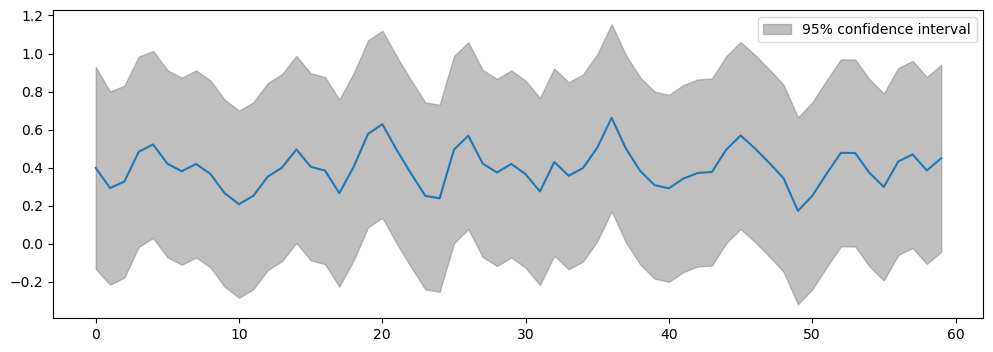

In [27]:
fig = plot_predict(fit)
fig.set_figwidth(12)
fig.set_figheight(4)

* wide 95% confidence interval is not good

In [15]:
residuals = fit.resid

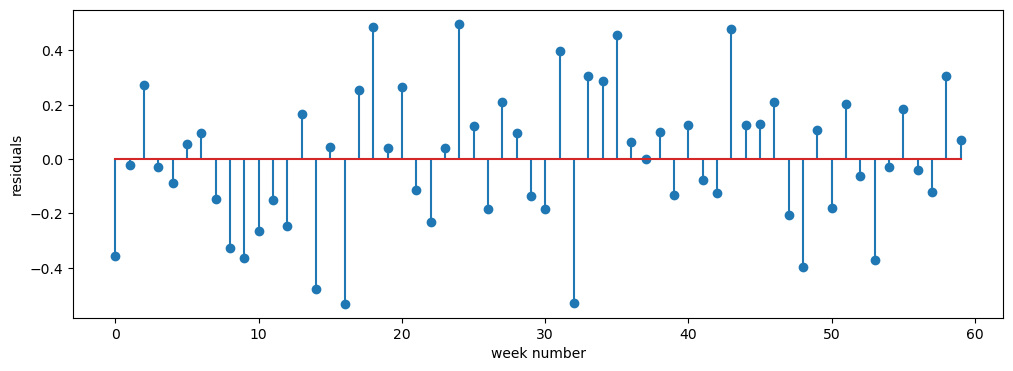

In [16]:
plt.figure(figsize=(12,4))
plt.ylabel('residuals')
plt.xlabel('week number')
plt.stem(residuals);

* large residuals are not good

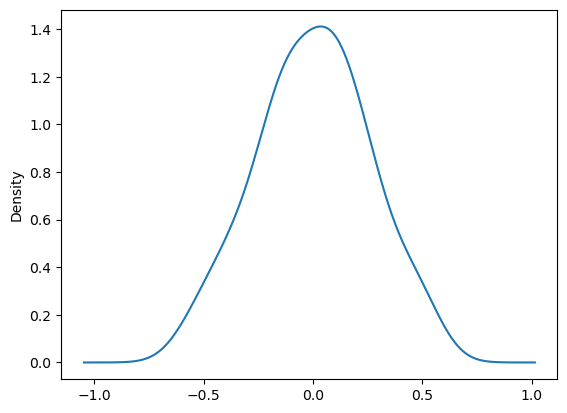

In [17]:
pd.Series(residuals).plot(kind='kde');

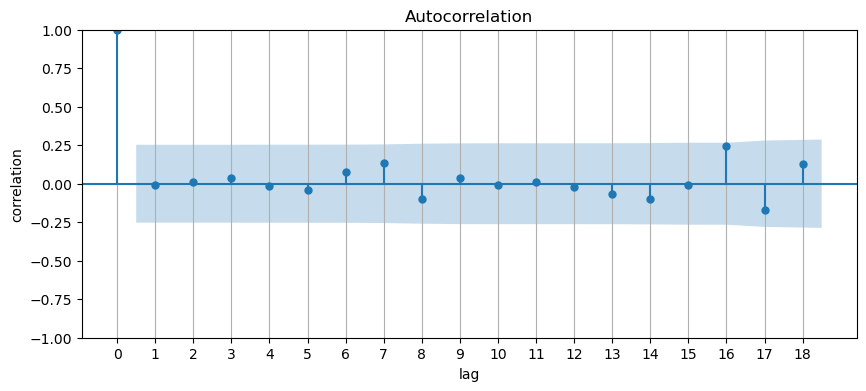

In [18]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(4)
ax.set_xticks(range(0,19))
ax.set_xlabel('lag')
ax.set_ylabel('correlation')
ax.grid(axis='x')
plot_acf(residuals, ax);

* not correlated residuals are good

## Prediction and Evaluation

In [19]:
prediction = fit.predict(51, 60)

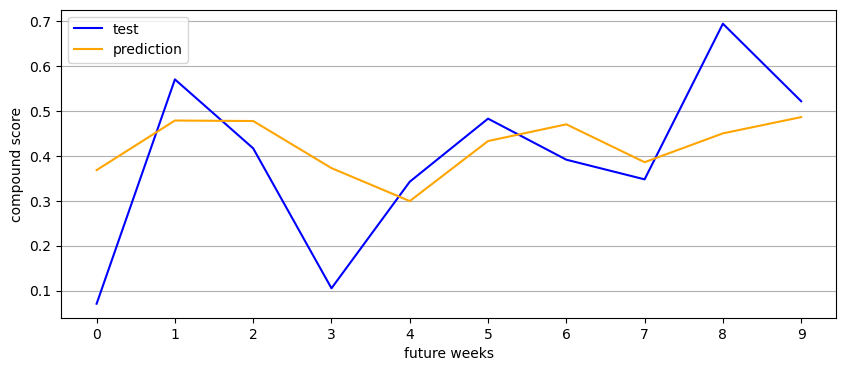

In [20]:
plt.figure(figsize=(10,4))
plt.xticks(np.arange(0,11))
plt.xlabel('future weeks')
plt.ylabel('compound score')
plt.plot(test, color='blue', label='test')
plt.plot(prediction, color='orange', label='prediction')
plt.grid(axis='y')
plt.legend();

* not bad based on all of the findings previously

In [23]:
error = test - prediction

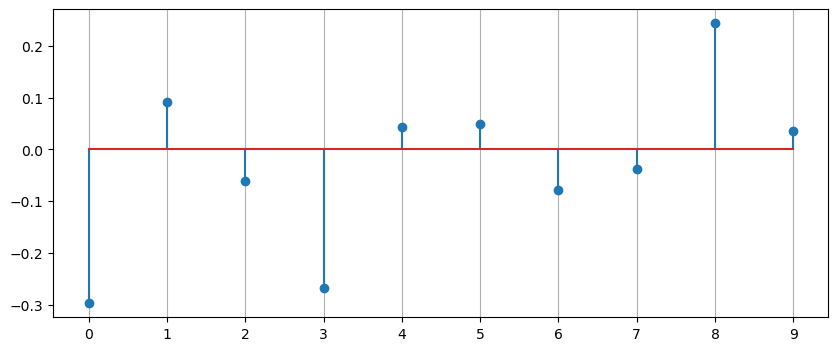

In [24]:
plt.figure(figsize=(10,4))
plt.xticks(range(10))
plt.grid(axis='x')
plt.stem(error);

## Performance Metric
The Root Mean Square Error (RMSE).

$$
\LARGE{\text{RMSE} = \sqrt{\frac{\sum(y - \hat y)^2}{n}}}
$$

In [25]:
RMSE = np.sqrt( np.sum(error**2) / test.size )
RMSE

0.15631331442481383

* mid performance
* difficult to interpret after the transformation

## Results and Implications
1. Inference is unadvisable
    * Too many assumptions and simplifactions made.
3. Individual valence patterns and trends may exist for some people on a weekly or monthly bases.
    * In conjunction with psychological observation it may be possible to relate valence patterns with life events.
5. Generalized predictions on the other hand are unlikely.
    * People's dream valence, for the most, appear to be random. Thus, general predictions for all of people, or even groups of people seems unlikely.

---

# Just for fun model attempts / previous model explorations
* Moving Averages (MA) model
* ARMA (Combining AR and MA models)
* Also not promising for the goal predicting dream valence

## ARMA explorations and building understanding

Decisions Made:
* because the dates have been so unruly, I have have decided not to use the dates at all. While this may be considered inaccurate, I think it not only simplies the potential modeling, but also is a decent to do as dreams are inherentatly random.

In [79]:
path = 'data/diaries/diary01.csv'
df = pd.read_csv(path, sep='|')
df = df[['negative', 'neutral', 'positive', 'compound']]
df

,negative,neutral,positive,compound
0,0.010,0.948,0.041,0.6486
1,0.041,0.906,0.053,-0.1941
2,0.076,0.856,0.069,-0.1573
3,0.098,0.829,0.073,-0.9523
4,0.040,0.889,0.071,0.9639
...,...,...,...,...
417,0.030,0.936,0.034,0.2508
418,0.022,0.840,0.138,0.9885
419,0.043,0.844,0.113,0.9866
420,0.064,0.891,0.045,-0.7947


In [80]:
split_point = df.shape[0] - (df.shape[0] // 3)
train = df['compound'].values[:split_point]
test = df['compound'].values[split_point:]
full = df['compound'].values

### Data Exploration

The assumption of being stationary is required for the ARIMA model.

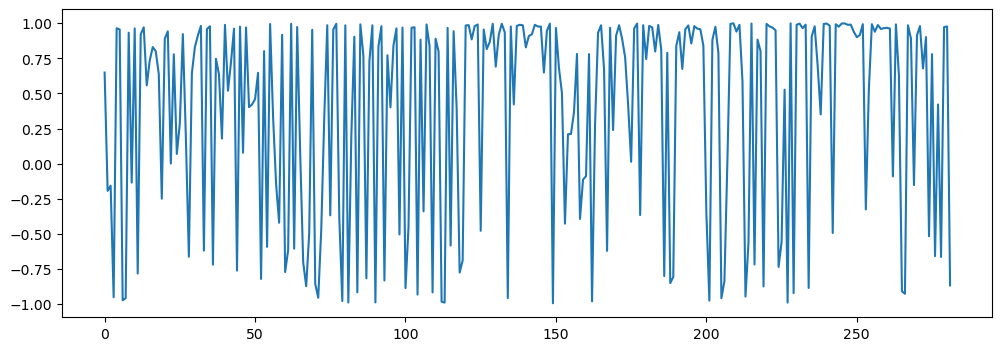

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train);

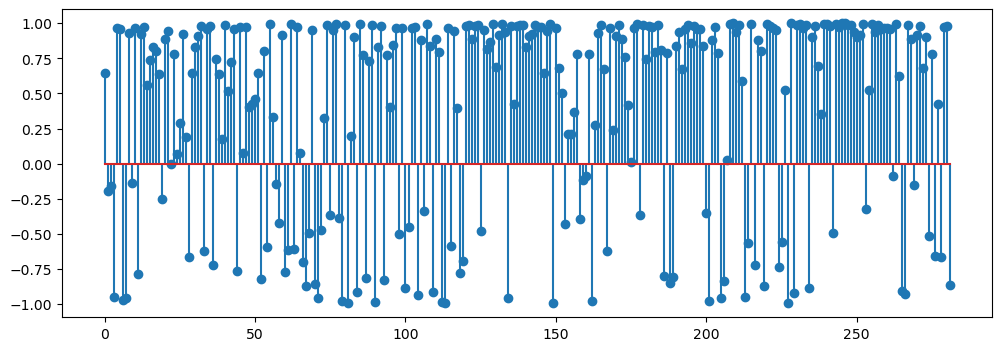

In [82]:
plt.figure(figsize=(12,4))
plt.stem(train);

Stationary basically just means that the values seen remains near some constant. In this case, the constant is 0, which makes sense as our data is restricted to the bounds [-1, 1].

I want to investigate any potential seasonality. As the data is quite eradict, I will try weekly and monthly periods.

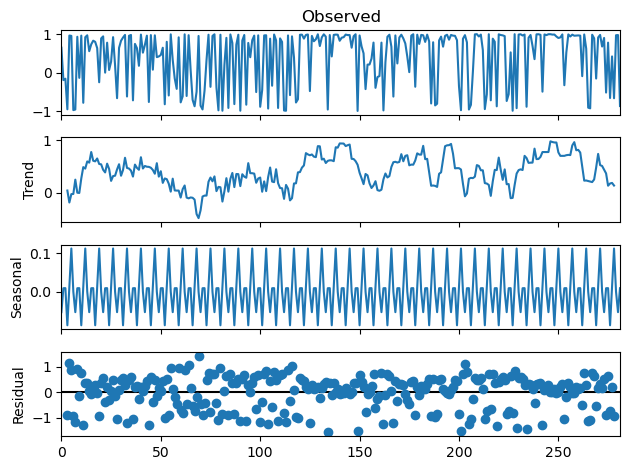

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(train, period=7).plot();

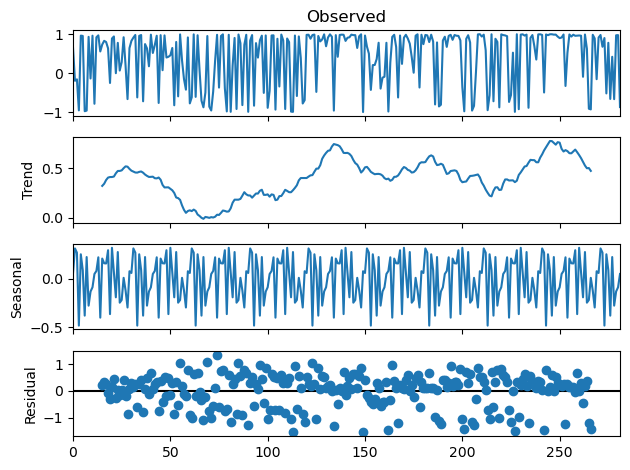

In [84]:
seasonal_decompose(train, period=30).plot();

Here we can see that there is strong seasonal effects, but they seem to be errestective of the trend, indicating a potential lack of predictability. This is likely due to the random nature of our data. To test this I will compare to a known random set.

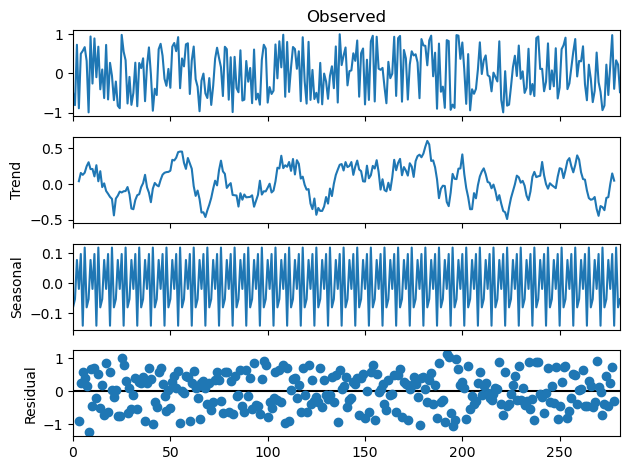

In [85]:
r = np.random.uniform(-1.0, 1.0, train.size)
seasonal_decompose(r, period=7).plot();

After trying a few random samples, I have noticed a seasonal effect will always appear. On the otherhand, the trend plot seems to be centered around zero, which would make sense for a random seed of values, but our data shows a 0 to about 0.75. Unfortuently, I am not entirely sure what this should suggest. My guess is that because the person being evaluated has more positive dreams than negative ones, this pattern is being revealed in the trend plot. To guage if this is true I will try to similate an increased amount of positive values above 0.

In [86]:
train.size

282

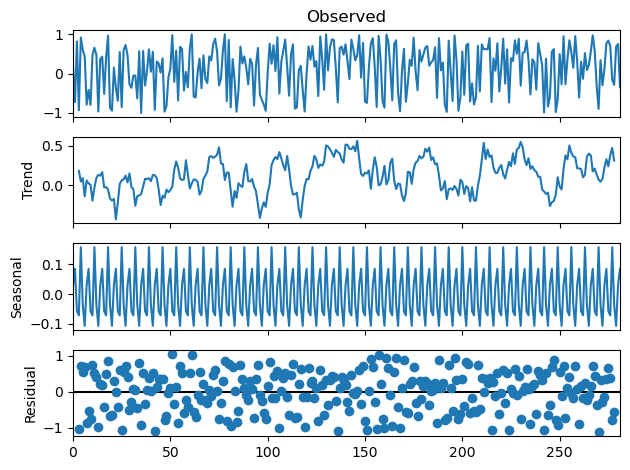

In [87]:
r = np.concatenate((
    np.random.uniform(-1.0, 1.0, 200),
    np.random.uniform(0.0, 1.0, 82)
))
np.random.shuffle(r)
seasonal_decompose(r, period=7).plot();

Lets try to increase the positivity rate

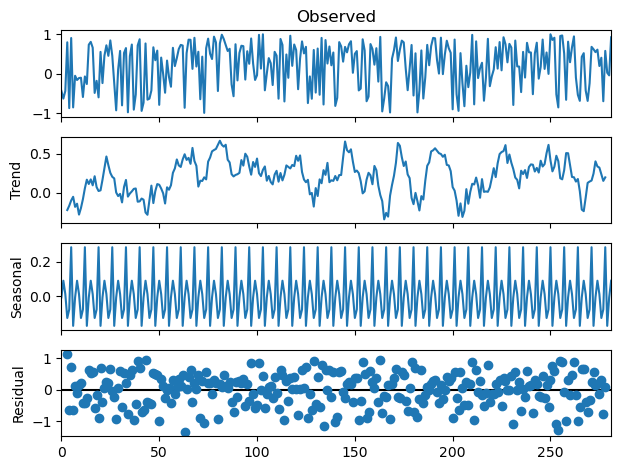

In [88]:
r = np.concatenate((
    np.random.uniform(-1.0, 1.0, 200),
    np.random.uniform(0.5, 1.0, 82)
))
np.random.shuffle(r)
seasonal_decompose(r, period=7).plot();

As we can see, the bimodal nature of the compound scores distribution is showing up in the trend plots above by shifting the plots above 0

To investigate further, I will create a rolling average for weekly and monthly periods.

In [89]:
weekly = []
a = 0
b = 7
while a < train.size:
    weekly.append(np.mean(train[a:b]))
    a += 7
    b += 7

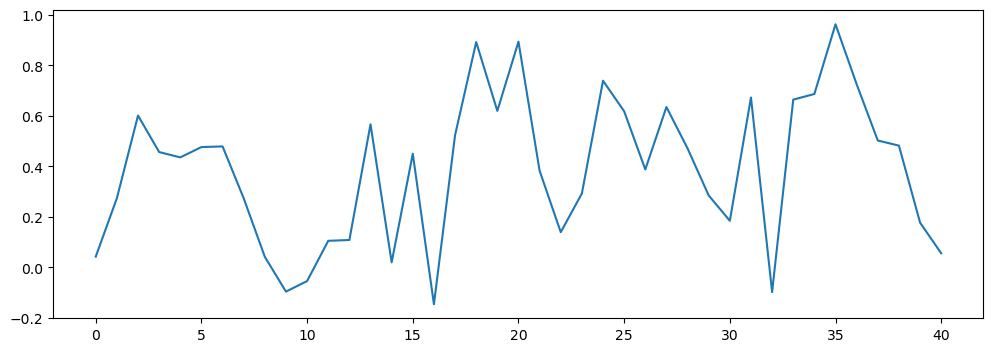

In [90]:
plt.figure(figsize=(12,4))
plt.plot(weekly);

In [91]:
monthly = []
a = 0
b = 30
while a < train.size:
    monthly.append(np.mean(train[a:b]))
    a += 30
    b += 30

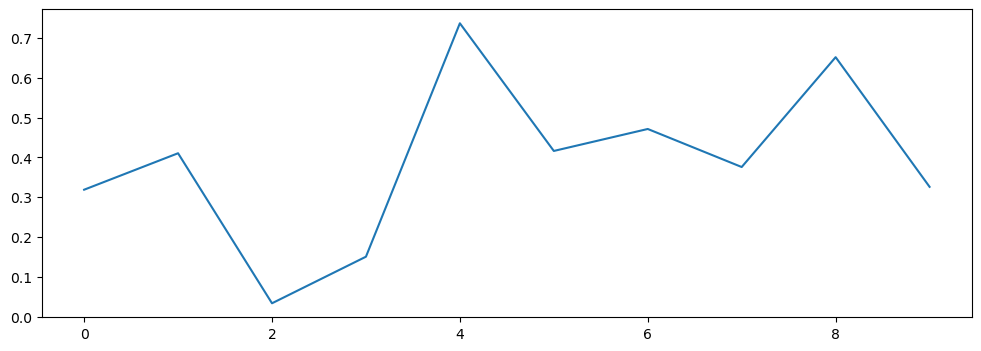

In [92]:
plt.figure(figsize=(12,4))
plt.plot(monthly);

As we can see, the weekly and monthly moving averages shift the plot to the positive side basically showing the same thing we determined with the bimodal distribution, the comparison with random values, and the seasonal decomposition plots.

Another way we can guage potential predictability is with the ACF. This is because we want to determine if the previous points are correlated with current points.

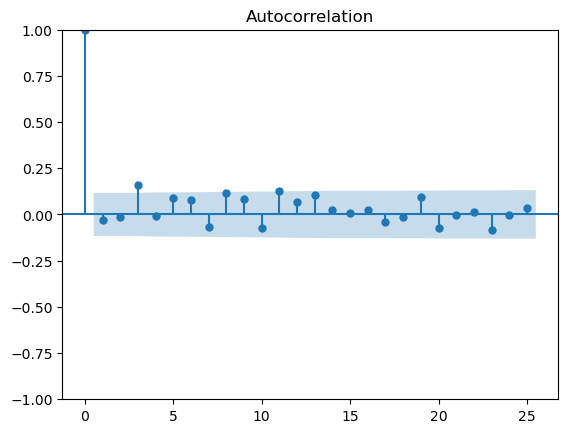

In [93]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train);

Here we see that the first lag is dramatic. But, this makes sense as a previous value does not exist. so, it results in a correlation of 1 and we can ignore it.

Next we see that the values here remain near zero at a range of lags. This means that the values are not correlated with any lags. aka, the data is likely unpredicatable, and bascially just white noise.

Now, I'm guessing he wants some numbers or "tests". Fortuently, for the "stationarity" the ADF test can be used for this.

In this test, the null-hypothesis is basically that the data is **non-stationary**.

In [94]:
from statsmodels.tsa.stattools import adfuller

# adfuller? index 1 has the p-value
f'{adfuller(train)[1]:.5f}' # i can't read scientfic notation well...

'0.00000'

Look at that low p-value! This means we reject the null hypothesis in favor of our alternate hypothesis i.e. our data is stationary! Of course we already knew this visually, as well as the fact that our data is restricted within [-1, 1].


Regardless of all of the above, I wanted to try to model the data anyways. My first attempt is below.

ARIMA(0, 1, 2)

In [95]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(0, 1, 2))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  282
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -306.237
Date:                Wed, 06 Mar 2024   AIC                            618.474
Time:                        20:23:05   BIC                            629.389
Sample:                             0   HQIC                           622.852
                                - 282                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0356      0.058    -17.728      0.000      -1.150      -0.921
ma.L2          0.0904      0.058      1.558      0.119      -0.023       0.204
sigma2         0.5135      0.061      8.447      0.000       0.394       0.633
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.25
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.75
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notice that ma.L2 has a highish p-value. I will accept it, and keep going.

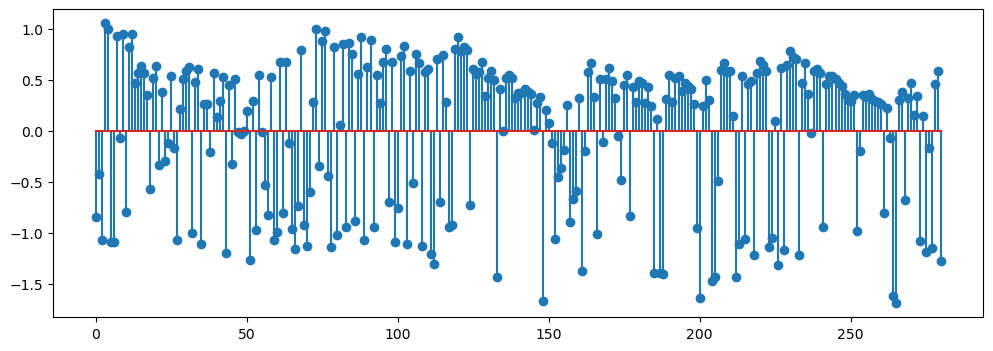

In [96]:
residuals = fit.resid[1:]
plt.figure(figsize=(12,4))
plt.stem(residuals);

Notice the significant degree of error across the predictions. Lets try a different view.

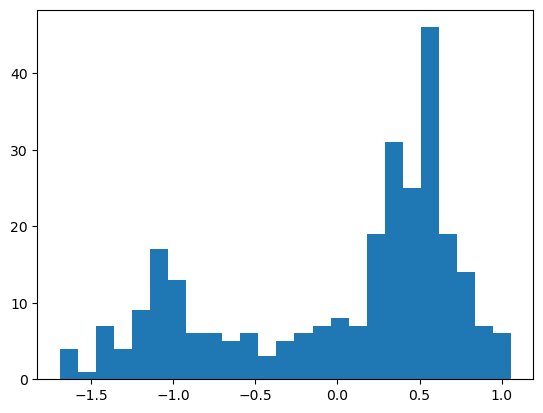

In [97]:
plt.hist(residuals, bins=25);

The biomodel distribution of the residuals is definitely not good for our purposes.

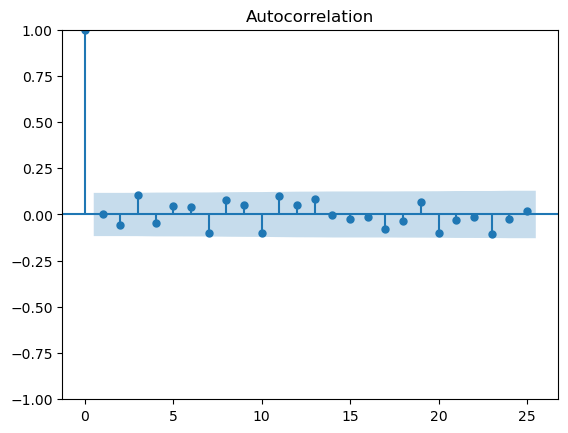

In [98]:
plot_acf(residuals);

This is looking good though as we want our residuals to not be correlated with previous residuals.

Let's plot the predictions!

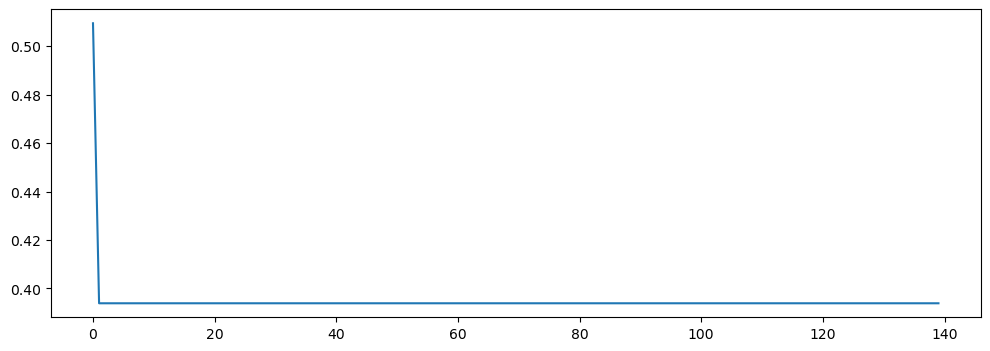

In [99]:
prediction = fit.forecast(test.size)

plt.figure(figsize=(12,4))
plt.plot(prediction);

obviously a bad prediction...

although, maybe we can do auto fitting of the proper ARIMA model parameters with someone elses library!

In [101]:
auto = pm.auto_arima(train, stepwise=False, seasonal=False)
auto

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True)

Here we can see it has given us the best possible model parameters. It does this behind the scene's by trying a bunch of different combinations.

In [102]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  282
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -303.219
Date:                Wed, 06 Mar 2024   AIC                            618.437
Time:                        20:23:49   BIC                            640.267
Sample:                             0   HQIC                           627.192
                                - 282                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.008      0.126      0.900      -0.014       0.016
ar.L1         -0.9253      0.039    -23.515      0.000      -1.002      -0.848
ma.L1         -0.0860      0.071     -1.206      0.228      -0.226       0.054
ma.L2         -0.9246      0.033    -28.332      0.000      -0.989      -0.861
ma.L3          0.1286      0.066      1.945      0.052      -0.001       0.258
sigma2         0.5016      0.083      6.069      0.000       0.340       0.664
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.73
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Turns out I might need to check out SARIMAX? Regardless, if we look at the p-values associated with this model, the intercept is bad and ma.L1 is also not great. Although I will accept this model and the p-values just for exploration.

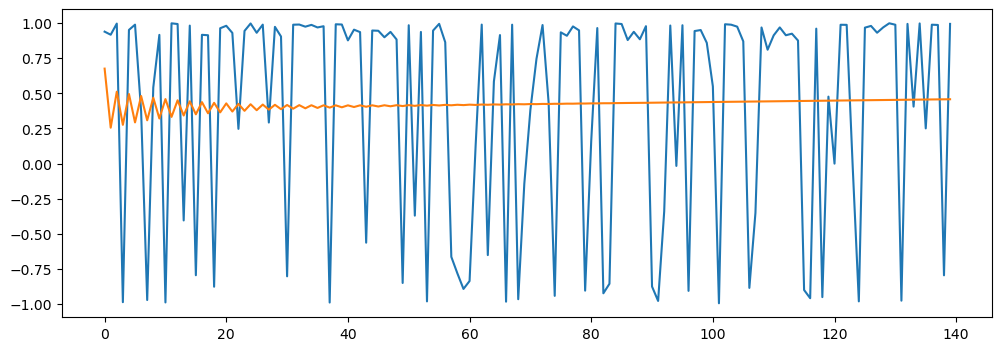

In [104]:
auto_predictions = auto.predict(n_periods=test.size)
plt.figure(figsize=(12,4))
plt.plot(test)
plt.plot(auto_predictions);

Still bad... However, not due to the model per se, but because our data is likely not predictable. However, we do see that this model at least obtains the somewhat back and forth nature of these dreams. It might very well be better to predict with 3 day, weekly, and monthly averages.

Or maybe try less predictions. essentially train on about a week or month, and try that.

#### Moving Averages (MA) Model
This model uses previously predicted errors in a regression-like manner. The idea is for past errors to provide information about future errors. This requires an interative approach to the modeling process, which is a bit over my head right now.

$$
y_t=\mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q}
$$

where

* $y_t$ is the compound score at time $t$
* $\mu$ is the mean of the compound scores
* $\theta_q$ is the "impact" of the previous predicted error
* $\epsilon_t$ is the error at time $t$
* $q$ is the order of the MA model indicating the number of lagged error checks to include

#### Assumptions and Checks
* errors are uncorrelated white noise
    * likely satisfied based on the residuals from the AR model
* equal variance
* finite lagged errors
* no hidden roots

In [28]:
path = 'data/diaries/diary01.csv'
df = pd.read_csv(path, sep='|')
df = df[['negative', 'neutral', 'positive', 'compound']]
df

,negative,neutral,positive,compound
0,0.010,0.948,0.041,0.6486
1,0.041,0.906,0.053,-0.1941
2,0.076,0.856,0.069,-0.1573
3,0.098,0.829,0.073,-0.9523
4,0.040,0.889,0.071,0.9639
...,...,...,...,...
417,0.030,0.936,0.034,0.2508
418,0.022,0.840,0.138,0.9885
419,0.043,0.844,0.113,0.9866
420,0.064,0.891,0.045,-0.7947


In [29]:
y = df['compound'].values

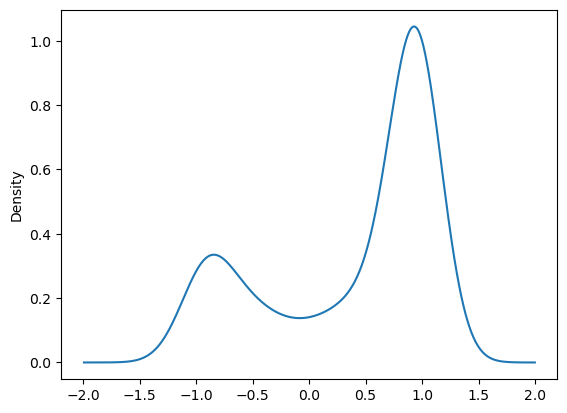

In [30]:
df['compound'].plot(kind='kde');

In [31]:
np.min(y), np.max(y)

(-0.9951, 0.9996)

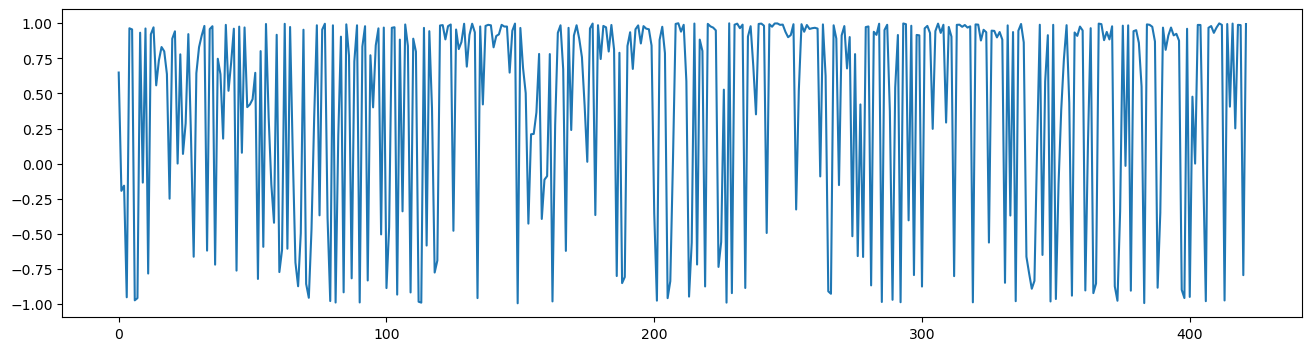

In [32]:
set_size = lambda: plt.figure(figsize=(16,4))
set_size()
plt.plot(y);

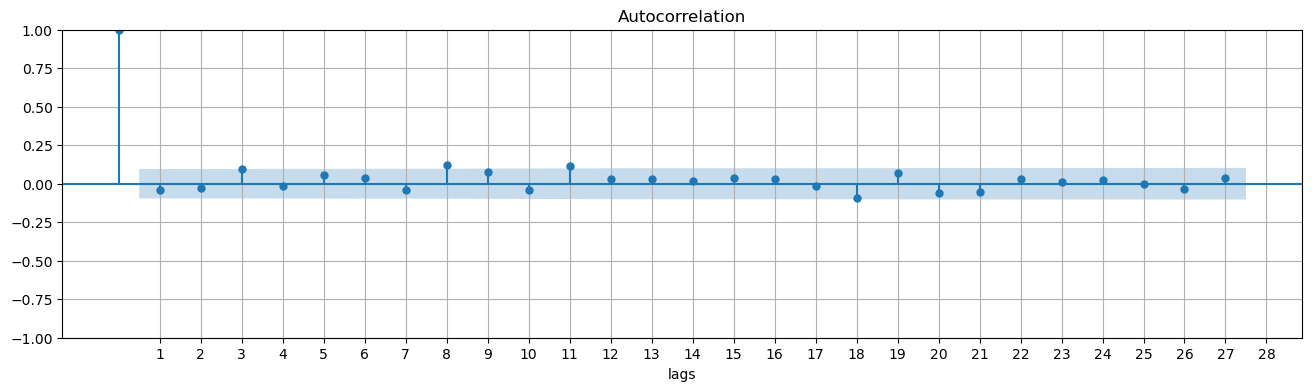

In [33]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(4)
ax.set_xticks(range(1, 31))
ax.grid()
ax.set_xlabel('lags')
plot_acf(y, ax);

This is not good for this model, but I will continue anyways.

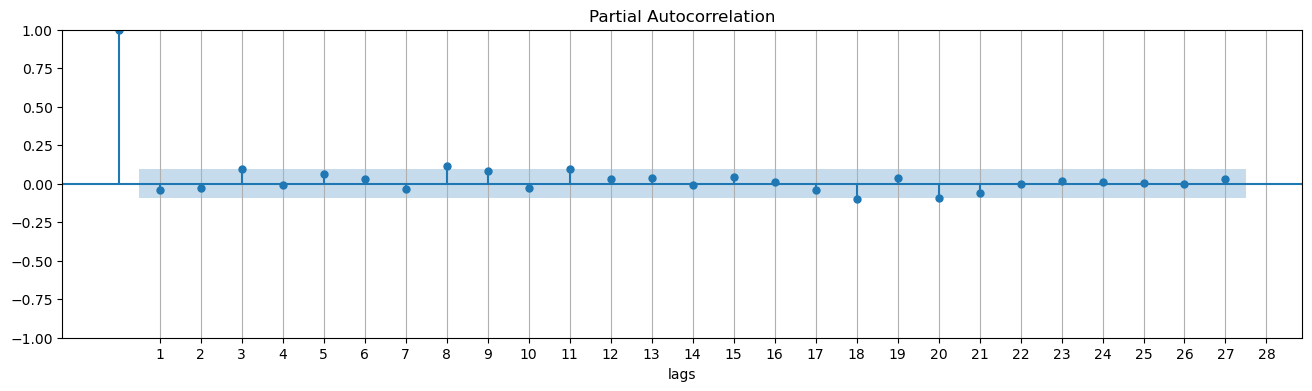

In [34]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(4)
ax.set_xticks(range(1, 31))
ax.grid(axis='x')
ax.set_xlabel('lags')
plot_pacf(y, ax);

Bascially the same, but I will continue anyways.

$y_{t-3}, y_{t-8}, y_{t-11},$ and maybe $y_{t-18}$ might be good lags to select.

thus, I will try a model upto 18 lags.

$$y_t=\beta_0+\beta_1y_{t-1}+...+\beta_{18}y_{t-18}+\epsilon$$

In [35]:
y.size

422

In [36]:
train = y[:400]
test = y[400:]

In [37]:
model = ARIMA(train, order=(18,0, 0))

In [38]:
fit = model.fit()

In [39]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:                ARIMA(18, 0, 0)   Log Likelihood                -429.127
Date:                Sat, 09 Mar 2024   AIC                            898.253
Time:                        09:35:10   BIC                            978.083
Sample:                             0   HQIC                           929.867
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3909      0.088      4.423      0.000       0.218       0.564
ar.L1         -0.0445      0.050     -0.889      0.374      -0.142       0.054
ar.L2         -0.0457      0.054     -0.852      0.394      -0.151       0.060
ar.L3          0.0695      0.053      1.313      0.189      -0.034       0.173
ar.L4         -0.0139      0.050     -0.279      0.780      -0.112       0.084
ar.L5          0.0662      0.051      1.307      0.191      -0.033       0.165
ar.L6          0.0449      0.051      0.876      0.381      -0.056       0.145
ar.L7         -0.0339      0.053     -0.633      0.527      -0.139       0.071
ar.L8          0.1120      0.052      2.173      0.030       0.011       0.213
ar.L9          0.1041      0.052      1.996      0.046       0.002       0.206
ar.L10         0.0049      0.053      0.092      0.927      -0.099       0.109
ar.L11         0.1031      0.052      1.996      0.046       0.002       0.204
ar.L12         0.0468      0.054      0.873      0.382      -0.058       0.152
ar.L13         0.0465      0.051      0.921      0.357      -0.052       0.146
ar.L14        -0.0043      0.054     -0.079      0.937      -0.111       0.102
ar.L15         0.0504      0.050      1.001      0.317      -0.048       0.149
ar.L16         0.0101      0.051      0.199      0.842      -0.089       0.109
ar.L17        -0.0793      0.056     -1.411      0.158      -0.190       0.031
ar.L18        -0.1259      0.060     -2.104      0.035      -0.243      -0.009
sigma2         0.4994      0.080      6.263      0.000       0.343       0.656
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                49.51
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.76
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here we can see that lag 3's p-value isnt quite where we want it, lag 8 is though, so is 11, and 18 is pretty good too. We also get lag 9 which I did suspect.

In [40]:
y_hat = fit.predict(400, y.size-1)

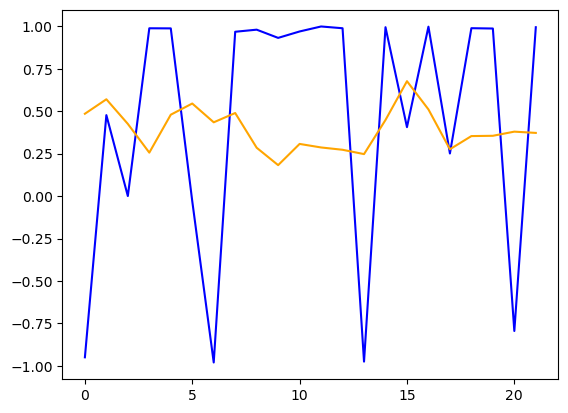

In [41]:
plt.plot(test, color='blue')
plt.plot(y_hat, color='orange')

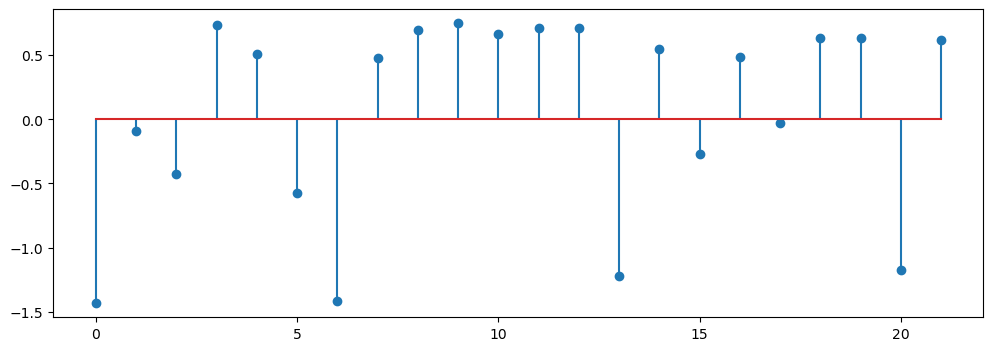

In [42]:
plt.figure(figsize=(12, 4))
plt.stem(test - y_hat);

In [43]:
# root mean sqaured error
RMSE = np.sqrt(np.sum(test - y_hat) ** 2 / y_hat.size)
RMSE

0.32919866044522056

overall poor performance

Lets try up to 30 lags

In [44]:
model = ARIMA(train, order=(30,0, 0))

In [45]:
y_hat = model.fit().predict(400, y.size-1)

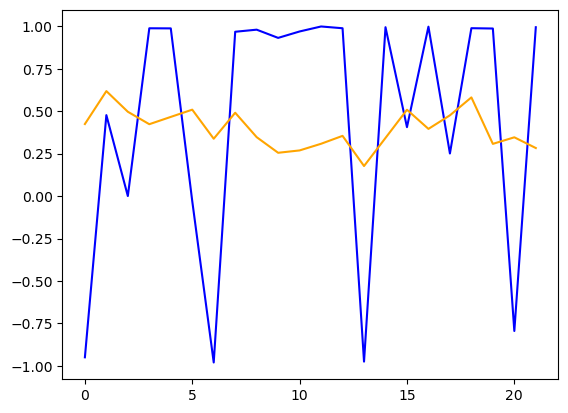

In [46]:
plt.plot(test, color='blue')
plt.plot(y_hat, color='orange')

In [47]:
np.sqrt(np.sum(test - y_hat) ** 2 / y_hat.size)

0.3118348351108348

slight improvment, but still bad

maybe less lags?

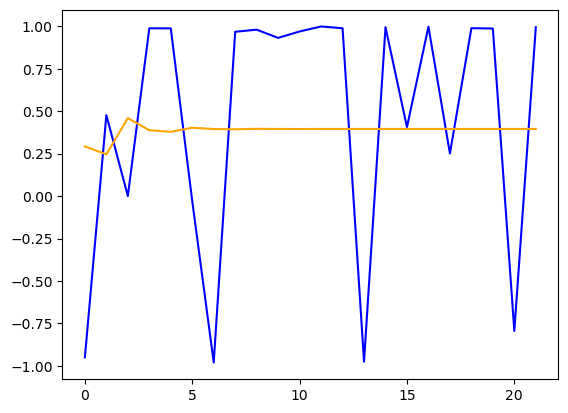

In [48]:
model = ARIMA(train, order=(3,0,0))
y_hat = model.fit().predict(400, y.size-1)
plt.plot(test, color='blue')
plt.plot(y_hat, color='orange')

In [49]:
np.sqrt(np.sum(test - y_hat) ** 2 / y_hat.size)

0.36058124328839813

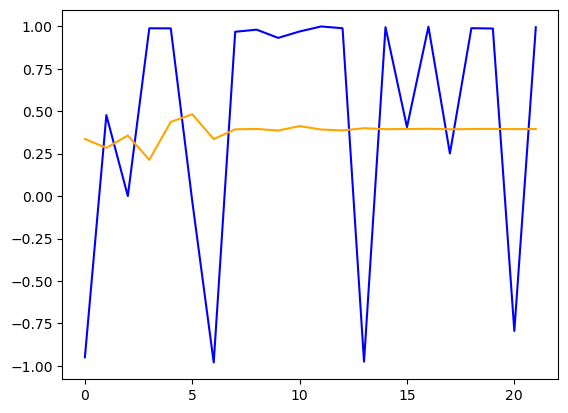

In [50]:
model = ARIMA(train, order=(7,0,0))
y_hat = model.fit().predict(400, y.size-1)
plt.plot(test, color='blue')
plt.plot(y_hat, color='orange')

In [51]:
np.sqrt(np.sum(test - y_hat) ** 2 / y_hat.size)

0.38618737606411446

### 3 day, 7 day, and 30 day averaged

In [52]:
# end indexes
df.shape[0] // 3 * 3, df.shape[0] // 7 * 7, df.shape[0] // 30 * 30

(420, 420, 420)

nice...

In [53]:
y = df['compound'].values[:420]

In [54]:
def apply_to_period(f, x, p):
    return np.array([
        f( x[i:i+p] )
        for i in np.arange(0, x.size, p)
    ])

In [55]:
y_avg_3 = apply_to_period(np.mean, y, 3)
y_avg_7 = apply_to_period(np.mean, y, 7)
y_avg_30 = apply_to_period(np.mean, y, 30)

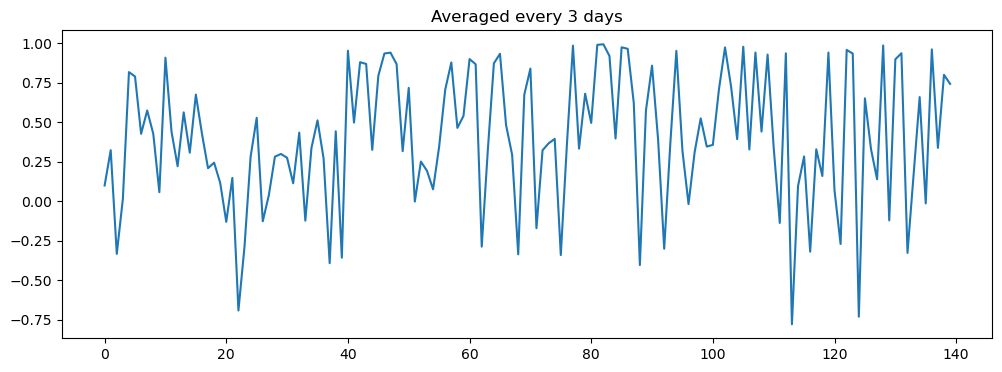

In [56]:
plt.figure(figsize=(12,4))
plt.title('Averaged every 3 days')
plt.plot(y_avg_3);

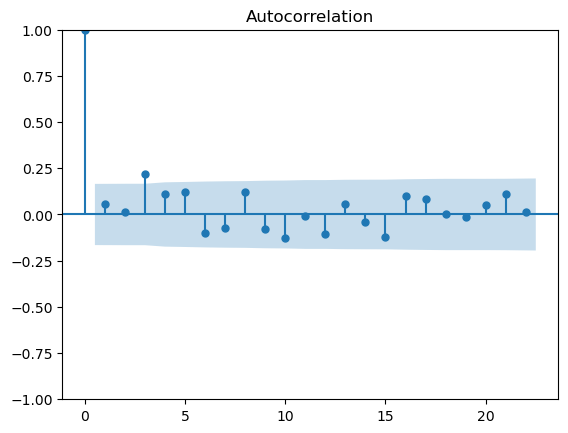

In [57]:
plot_acf(y_avg_3);

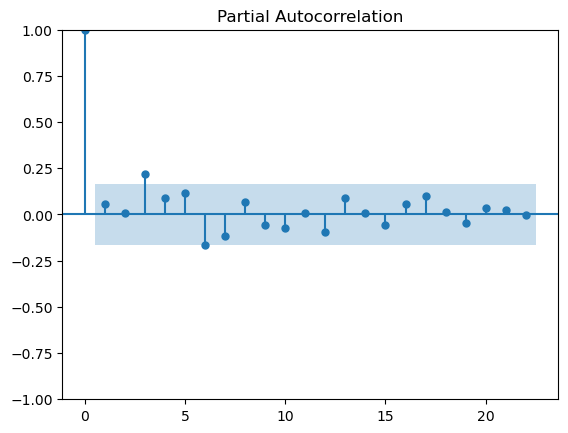

In [58]:
plot_pacf(y_avg_3);

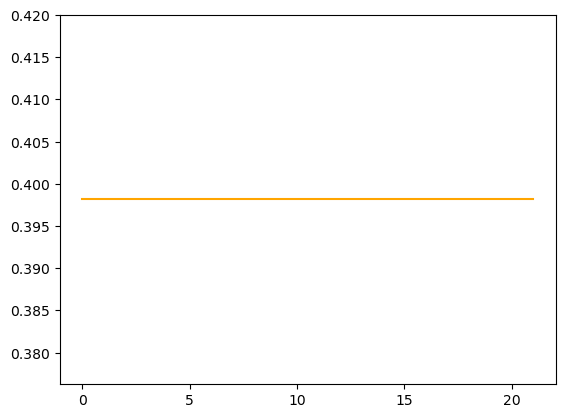

In [59]:
model = ARIMA(y_avg_3[:400], order=(6,0,0))
y_hat = model.fit().predict(400, 421)
plt.plot(y_avg_3[400:], color='blue')
plt.plot(y_hat, color='orange');

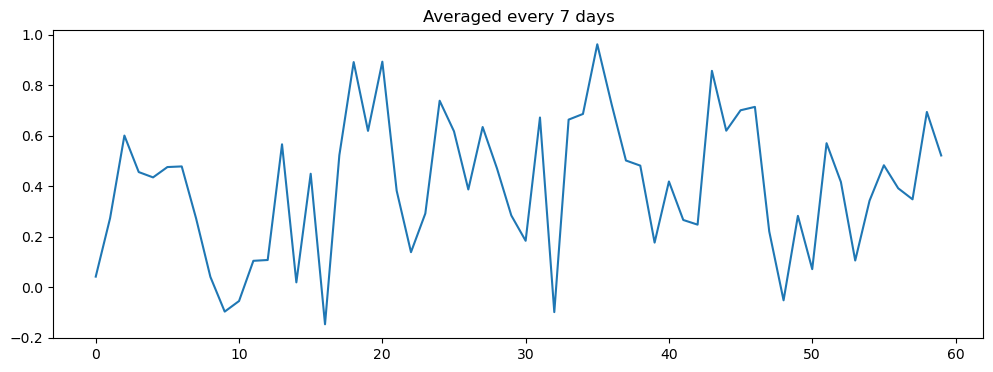

In [60]:
plt.figure(figsize=(12,4))
plt.title('Averaged every 7 days')
plt.plot(y_avg_7);

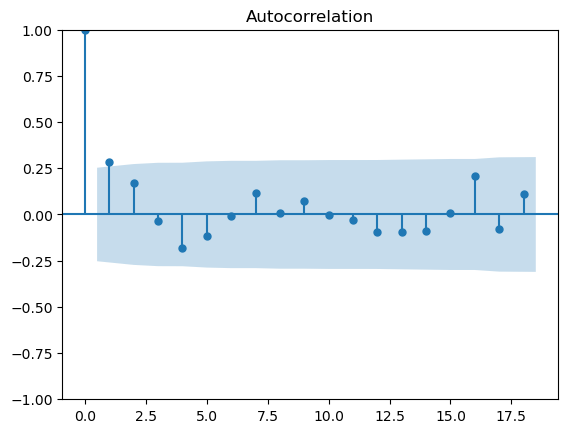

In [61]:
plot_acf(y_avg_7);

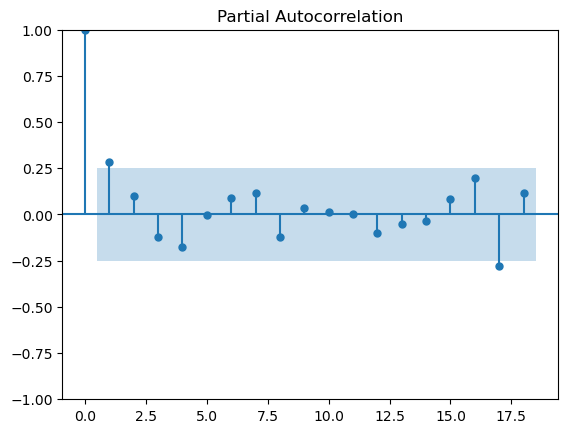

In [62]:
plot_pacf(y_avg_7);

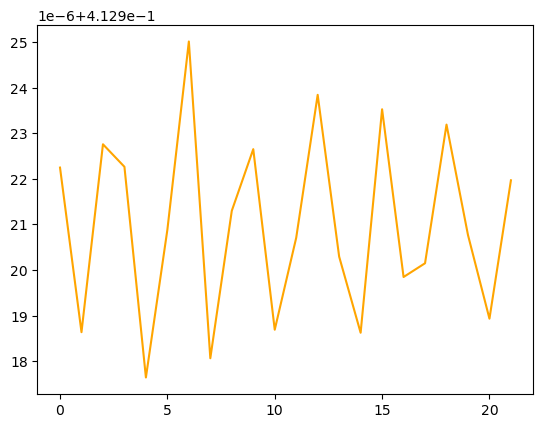

In [63]:
model = ARIMA(y_avg_7[:400], order=(17,0,0))
y_hat = model.fit().predict(400, 421)
plt.plot(y_avg_7[400:], color='blue')
plt.plot(y_hat, color='orange');

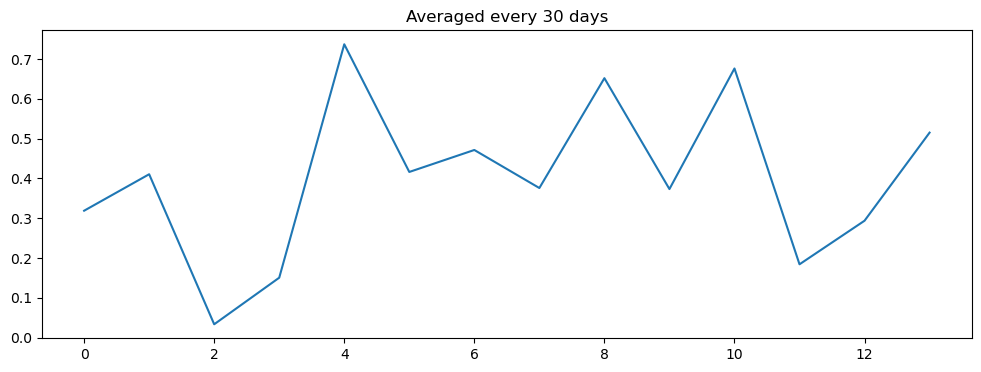

In [64]:
plt.figure(figsize=(12,4))
plt.title('Averaged every 30 days')
plt.plot(y_avg_30);

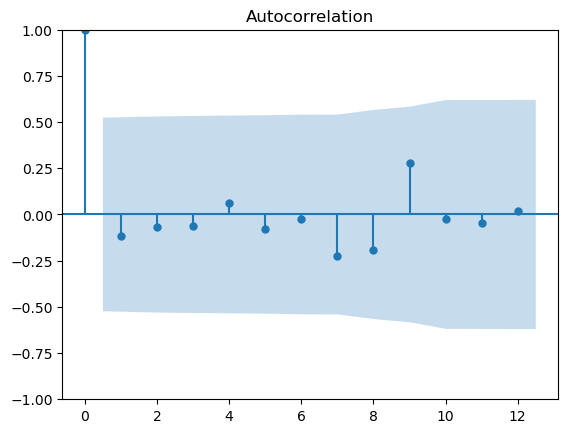

In [65]:
plot_acf(y_avg_30);